# Preliminary: install NiWorkflows

*NiWorkflows* is yet another component (perhaps the eldest) of *NiPreps*.

It contains utilities and workflows to support end-user *NiPreps*:

- Visual Reports (reportlet generation, visualization and agreggation system)
- Extensions to NiPype Interfaces
- Workflows commonly used across *NiPreps*

In [3]:
!pip install --user "niworkflows >= 1.2.6"

For this notebook, we just need to import one simple adaptor of the so-called "reportlets" to be displayed in the notebook.

In [4]:
from niworkflows.viz.notebook import display

Now that we are at it, let's also get nitransforms installed

In [13]:
!pip install nitransforms

# NiTransforms

*NiTransforms* is a small project with the vision of NiBabel, but for the case of spatial transforms.

### Spatial transforms, what's that?
Images have (at least) two coordinate spaces: voxels (i.e., the actual data array), and physical coordinates (which is built on top of the data array).

Because images of the same subject may not be acquired on the same session, it is expected that, if you visualize them together, their features and objects (for instance, the brain) will not be aligned.

**Image registration** is the methodology to estimate the *spatial transform* that alignes two given images. This is done by analyzing the information in a reference image and the other image (the *moving* image) that we want to see aligned with the reference.

### Why is this an open problem?

There are many tools to perform image registration. While NIfTI has become a somewhat-preferred standard to transfer images, this is not the case for spatial transforms - the subproduct of image registration.

In other words, each software tool reads and writes spatial transforms in its own format with little (if any) compatibility with other tools.

# Let's have a look

Data for this example are found under `~/data/nipreps/nitransforms`

In [6]:
from pathlib import Path
DATA_PATH = Path.home() / "data" / "nipreps" / "nitransforms"

First, we use NiBabel to inspect the preprocessed T1w image and one BOLD run from ds000114:

In [11]:
import nibabel as nb
t1w_nii = nb.load(DATA_PATH / "sub-05_desc-preproc_T1w.nii.gz")
print(
    f"The T1w image has a size of {'x'.join(str(i) for i in t1w_nii.shape[:3])} voxels "
    f"with resolution {'x'.join(str(i) for i in t1w_nii.header.get_zooms()[:3])} mm."
)

The T1w image has a size of 256x156x256 voxels with resolution 1.0x1.299488x1.0 mm.


In [18]:
bold_nii = nb.load(DATA_PATH / "sub-05_ses-test_task-fingerfootlips_boldref.nii.gz")
print(
    f"The BOLD image has a size of {'x'.join(str(i) for i in bold_nii.shape[:3])} voxels "
    f"with resolution {'x'.join(str(i) for i in bold_nii.header.get_zooms()[:3])} mm."
)

The BOLD image has a size of 64x64x30 voxels with resolution 4.0x4.0x4.0000234 mm.


Because both images have very different size and resolution, we can't use the reportlets. Let's generate a new version of the BOLD image, but with a grid exactly the same of that of the T1w image.

We can use the identity transform and *NiTransforms* for it.

First, we create a new spatial transform called `identity_xfm`, with reference to the T1w image. If we don't specify a `matrix`, then it will be set to identity by default.

In [19]:
import nitransforms as nt
identity_xfm = nt.linear.Affine(reference=t1w_nii)
identity_xfm.matrix

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

We can now resample our BOLD data on the T1w image grid, and check that the resolution and size match the T1w. All transform objects in nitransform have the `.apply()` method, with resamples the image passed in as the first arguments into the reference's space via the transform.

In [21]:
resampled_in_t1 = identity_xfm.apply(bold_nii)
print(
    f"The resampled BOLD image has a size of {'x'.join(str(i) for i in resampled_in_t1.shape[:3])} voxels "
    f"with resolution {'x'.join(str(i) for i in resampled_in_t1.header.get_zooms()[:3])} mm."
)

The resampled BOLD image has a size of 256x156x256 voxels with resolution 1.0x1.299488x1.0 mm.


Let's check what's going on

In [22]:
display(t1w_nii, resampled_in_t1)

# You're right, those brains are not aligned

Because fMRIPrep has run the image registration process for the BOLD image with reference to the T1w image, we can use the transform file to bring both into alignment.

In [23]:
t1w_to_bold_xfm = nt.linear.load(DATA_PATH / "sub-05_ses-test_task-fingerfootlips_to-T1w_mode-image_xfm.txt", fmt="itk")
t1w_to_bold_xfm.reference = t1w_nii

In [24]:
moved_to_t1 = t1w_to_bold_xfm.apply(bold_nii)
print(
    f"The resampled BOLD image has a size of {'x'.join(str(i) for i in moved_to_t1.shape[:3])} voxels "
    f"with resolution {'x'.join(str(i) for i in moved_to_t1.header.get_zooms()[:3])} mm."
)

The resampled BOLD image has a size of 256x156x256 voxels with resolution 1.0x1.299488x1.0 mm.


Hopefully, fMRIPrep (actually, FreeSurfer's bbregister) estimated a good transform. Let's see...

In [25]:
display(t1w_nii, moved_to_t1)

# Yay!
**But I want to move some prior knowledge from the T1w onto the BOLD.**
In other words, you want to apply the inverse transform and have the BOLD act as the reference.

Well, NiTransforms got you covered.

**NiTransforms implements Python operators**
(and inversion `~` is one of those).

In [26]:
# Inverting the transform is as easy as:
bold_to_t1w_xfm = ~t1w_to_bold_xfm
# Then, we set the new reference
bold_to_t1w_xfm.reference = bold_nii

Way to go! Let's apply the transform in a one-liner:

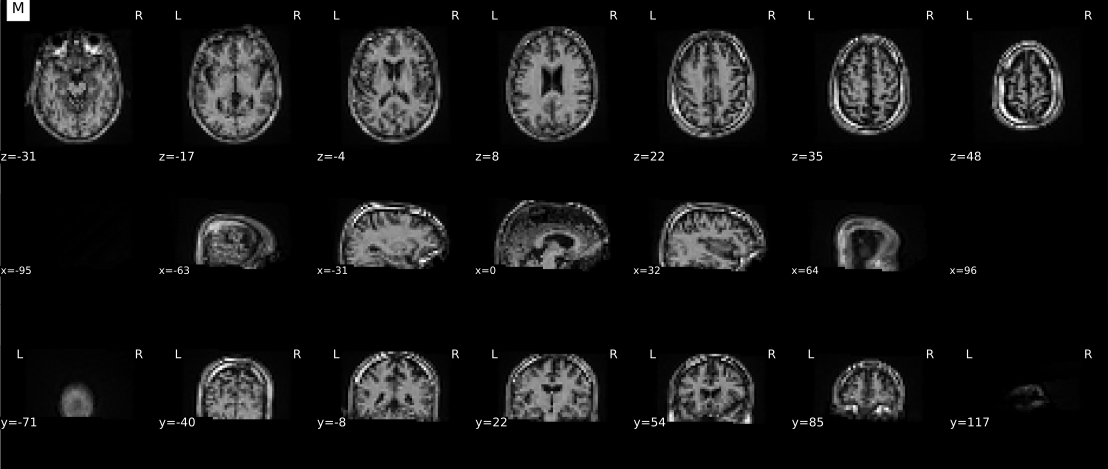

In [27]:
display(bold_nii, bold_to_t1w_xfm.apply(t1w_nii))

That seems fair, but at this point I know that:
- Many studies run group level analysis and report in *standardized coordinates*
- *fMRIPrep* estimates a nonlinear transform between the T1w and arbitrary templates.

### Is it possible to concatenate this transform (BOLD-to-T1w) with the spatial normalization (T1w-to-MNI) to get my data aligned to a standard space?

Let's load the T1w-to-MNI transform first.